# Project goals

The main goal of this project will be using machine learning techniques to **train a model that can determine whether a given sentence (i.e., subtitle line) represents the Spanish spoken in Spain or the Spanish spoken in Mexico**. 

The main challenge is that subtitle lines tend to be short (not many words) and might thus not be very informative for the model. This, in turn, could result in low accuracy scores. On the other hand, if the vocabulary and grammar vary enough from line to line, the model should not have many difficulties in determining the dialect despite working with short sentences. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Data Acquisition, Selection, Cleaning

The data is in a .csv file hosted on my personal Github account. I made the Github repository public and imported it to this notebook in the form of a pandas dataframe.


In [3]:
def install_data():
  url = 'https://raw.githubusercontent.com/irhuru/dialect-classifier/main/spanish_subtitles_corpus.csv'
  df = pd.read_csv(url)
  df = df.dropna(how='all', axis='columns')
  return df

df = install_data()
df.head(5)

,line,subtitle,movie,country
0,1,Me gustarÍa ser un hombre,dolor_y_gloria,spain
1,2,para baÑarme en el rÍo desnuda.,dolor_y_gloria,spain
2,3,¡QuÉ valor!,dolor_y_gloria,spain
3,4,"¡QuÉ cosas tienes, Rosita!",dolor_y_gloria,spain
4,5,Di que sÍ.,dolor_y_gloria,spain


The dataframe contains 4 columns:

* Line: each subtitle line is numbered (this number restarts whenever the movie title changes)
* Subtitle: the actual text from each subtitle line
* Movie: movie title
* Country: country where the movie is from (either Spain or Mexico)

In [4]:
def data_shape(df):
  df_shape = df.shape
  print("This dataframe has", df_shape[0], "rows and", df_shape[1], "columns")

data_shape(df)

This dataframe has 12854 rows and 4 columns


For some reason, all characters containing diacritics (e.g., "á", "ñ"...) are capitalized. Therefore, I decided to normalize the text by making them lowercase. Additionally, I also removed all special characters from the text (subtitle column).

In [5]:
df['subtitle'] = [text.lower() for text in df['subtitle']]

df['subtitle'] = [re.sub(r'\W+', ' ', text) for text in df['subtitle']]

df.head(5)

,line,subtitle,movie,country
0,1,me gustaría ser un hombre,dolor_y_gloria,spain
1,2,para bañarme en el río desnuda,dolor_y_gloria,spain
2,3,qué valor,dolor_y_gloria,spain
3,4,qué cosas tienes rosita,dolor_y_gloria,spain
4,5,di que sí,dolor_y_gloria,spain


# Data Exploration

In order to become more familiar with the data, I decided to calculate the total number of subtitle lines for each country and for each movie. 

I did this by using pandas on the dataframe and by plotting the results. I used the `seaborn` library for the plots.


AxesSubplot(0.125,0.125;0.775x0.755)


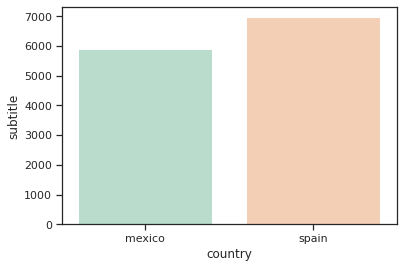

In [6]:
def lines_per_country(df):
  return df.groupby('country', as_index=False).count()[['subtitle', 'country']]

def plot_per_country(df):
  mini_df = lines_per_country(df)
  sns.set_theme(style="ticks")
  sns.set_palette("Pastel2")
  return sns.barplot(x = "country", y = "subtitle", data = mini_df)

print(plot_per_country(df))

It looks like there are approximately 1,000 more subtitle lines from Spanish movies than from Mexican movies. 

AxesSubplot(0.125,0.125;0.775x0.755)


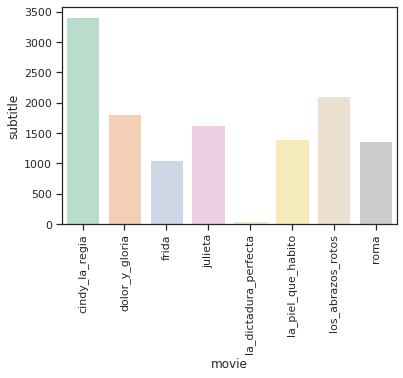

In [7]:
def lines_per_movie(df):
  return df.groupby('movie', as_index=False).count()[['subtitle', 'movie']]

def plot_per_movie(df):
  mini_df = lines_per_movie(df)
  sns.set_theme(style="ticks")
  sns.set_palette("Pastel2")
  plot = sns.barplot(x = "movie", y = "subtitle", data = mini_df)
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
  return plot

print(plot_per_movie(df))

The movie "Cindy la regia" (Mexico) has the most subtitle lines, whereas the movie "La dictadura perfecta" (also Mexico) barely has subtitle lines.

# Data Analysis

Since the data is already labeled (country: Spain or Mexico), I will use a **classification technique** in order to train a model that will tease apart whether a subtitle line is either characteristic from Spain or from Mexico.

There are several machine learning algorithms for classification, but I will be using a Naive Bayes classifier.

# Naive Bayes Classifier

Naive Bayes classifiers are very popular. These classifiers are **based on probabilities** (probabilistic models) and are derived from the famous Bayes' Theorem you have probably heard of before.

**Bayes' Theorem** is a simple mathematical formula to calculate conditional probabilities:

![picture](https://drive.google.com/uc?export=view&id=1jMgIQdBavDxHF-ms8Tt4GBOUSGQVEI-v)

where

* P(A|B) is the probability of event A occurring, given event B has occurred;
* P(B|A) is the probability of event B occurring, given event A has occurred;
* P(A) is the probability of event A;
* P(B) is the probability of event B.  

If we were to apply this formula to our current data, we would replace A with a country (Spain or Mexico) and B with a sentence from our dataset. That way, we could calculate the probability of a sentence X being from either Spain or from Mexico. After we calculated those two probabilities (i.e., probability of sentence X being from Spain VS. probability of sentence X being from Mexico), we would choose the highest of the two to classify our sentence.

That is, *if the probability of sentence X being from Spain was higher than the probability of sentence X being from Mexico, then the model would classify sentence X as being from Spain*. In other words, for each sentence in our dataset, we would have to calculate these two formulas:

![picture](https://drive.google.com/uc?export=view&id=10yhgwIwJkByJvYXwIM7hEt1q1T30U2Yr)


![picture](https://drive.google.com/uc?export=view&id=1FuigPF5TcIuQQA6goFGXyu6miPp1ZF7S)


# Dealing with unique sentences

Ok, so far so good. But, **what happens if each sentence is unique?** That is, we might only have one instance of each sentence, so this would difficult our calculations, as the numerator would always be 1. And if each sentence is unique, then all probabilities might end up having the same value, which is a problem.


# Solution: Use Words!

A good solution for this would be to **use individual words instead of individual sentences**. This way, it is highly likely that words will be repeated across sentences, so the probability values will be more diverse. 

Also, it makes sense for the data we are dealing with, as some words may be characteristic of a certain dialect regardless of the sentence they are used in, so the model could learn that "tendency" and predict the dialect based on a specific word.

# Preprocessing

Before using a Naive Bayes classifier algorithm, we need to "tweak" our dataset a bit, since we have full subtitle sentences instead of individual words. Also, we need to split our dataset into training and testing set too.

Fortunately, we can use scikit-learn for these two things.

## Label encoding

The first thing we will do is to change the 'country' labels to 0 and 1 instead of 'Spain' and 'Mexico'. This is known as label encoding, and it is required to later apply our machine learning algorithm. 

We can do this manually or we can use a preprocessing class from scikit-learn. I decided to go with this latter. You can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])
print(df.head(5)) # Spain is 1 and Mexico is 0 (alphabetical order)

   line                         subtitle           movie  country
0     1        me gustaría ser un hombre  dolor_y_gloria        1
1     2  para bañarme en el río desnuda   dolor_y_gloria        1
2     3                       qué valor   dolor_y_gloria        1
3     4         qué cosas tienes rosita   dolor_y_gloria        1
4     5                       di que sí   dolor_y_gloria        1


## Training and Testing Datasets

The next step is to split our dataset into training and testing set. It is common practice to use 70% of the data for training and 30% for testing.

I used scikit-learn too for this step. The output of `train_test_split` consists of four datasets: `X_train`, `X_test`, `y_train`, and `y_test`. The ones that start with an X refer to our independent variable or features (aka. subtitle), whereas those that start with y refer to our dependent variable or labels (aka. country). 

![picture](https://drive.google.com/uc?export=view&id=1C1qkL_ohkLtNbkrtXOwAxVi35S0HkF6h)

The hyperparameter `test_size` refers to the percentage of data that we want to use for the testing dataset. In this case, it is 0.3, which is equivalent to 30% of the full dataset. The hyperparameter `random_state` is simply a random number that we can include for replicability purposes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['subtitle'], df['country'], test_size=0.3,random_state=142)

We can explore our new datasets to see how many elements they include by using the `describe()` function from Python.

In [ ]:
def explore_set(dataset):
  return dataset.describe()

print(explore_set(X_train))
print(explore_set(X_test))
print(explore_set(y_train))
print(explore_set(y_test))

count     8997
unique    8276
top        sí 
freq        46
Name: subtitle, dtype: object
count     3857
unique    3626
top        sí 
freq        17
Name: subtitle, dtype: object
count    8997.000000
mean        0.537957
std         0.498585
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: country, dtype: float64
count    3857.000000
mean        0.550946
std         0.497462
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: country, dtype: float64


## From Subtitle Sentences to Words 

The last preprocessing step is to split our dataset into individual words. I used `CountVectorizer` for this. I applied it on the training data only (`X_train`). 

In [ ]:
vectorizer = CountVectorizer()
training_data = vectorizer.fit_transform(X_train.values)

We have now built a vocabulary that we can check out by using `vectorizer.vocabulary_`. Since this would be very long to show (too many words!), the code below shows the first 20 words only.

In [ ]:
dict(list(vectorizer.vocabulary_.items())[:20])

{'ahí': 232,
 'ay': 581,
 'ch': 1009,
 'de': 1603,
 'debería': 1609,
 'del': 1676,
 'está': 2419,
 'hablamos': 2824,
 'labios': 3314,
 'mucho': 3899,
 'no': 4045,
 'offlectora': 4125,
 'psicóloga': 4815,
 'ser': 5409,
 'sí': 5655,
 'te': 5702,
 'vale': 6038,
 'viaje': 6164,
 'viendo': 6177,
 'yo': 6309}

# Fitting the model

Now that our training dataset has been preprocessed, we can fit a Naive Bayes classifier model. 

But, what model exactly? There are 3 different types of Naive Bayes classifiers:

* **Gaussian**: used for continuous data with a normal distribution.
* **Bernoulli**: used for binomial data with 0's and 1's (either presence or absence).
* **Multinomial**: used for discrete data. Not only interested in the presence or absence of a feature, but also on how frequent the feature is.

Given the nature of our data, we will use a **Multinomial Naive Bayes classifier**, since we are interested in frequency counts. 

The code below shows how we can fit this model to our training data. Note the hyperparameter `alpha`. Its current value `1.0` indicates that we want to apply **Laplace smoothing** (aka. additive smoothing). This is important to avoid the [zero-frequency problem](https://medium.com/atoti/how-to-solve-the-zero-frequency-problem-in-naive-bayes-cd001cabe211). 



In [ ]:
naive_bayes_classifier = MultinomialNB(alpha=1.0)
naive_bayes_classifier.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Predicting the Testing Dataset

Once we have fitted our model, we can use it on the testing dataset to predict the countries (i.e., Spain or Mexico). Of course, we also need to transform it first into words.

In [ ]:
testing_data = vectorizer.transform(X_test.values)
y_pred = naive_bayes_classifier.predict(testing_data)

# Evaluating the Model

## Confusion Matrix

The last step is to evaluate our model. To do this, we can create a confusion matrix. A confusion matrix is an array with four values arranged in the following way:

![picture](https://drive.google.com/uc?export=view&id=1Fe1EWOMrX_lWF8dvhZ-6TsZ6cE_38rUC)


The code below shows how we can get a confusion matrix using scikit-learn and how we can then plot it using `seaborn`.

In [ ]:
def get_cmatrix(test_data, pred_data):
  return metrics.confusion_matrix(test_data, pred_data)

array_cf = get_cmatrix(y_test, y_pred)
print(array_cf)

[[1030  702]
 [ 415 1710]]


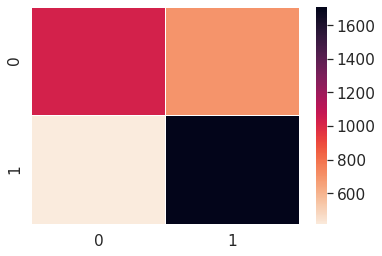

In [ ]:
df_cm = pd.DataFrame(array_cf, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=False, linewidths=.5, cmap="rocket_r")

plt.show()

There were more values correctly predicted than values incorrectly predicted.

## Other Metrics

There are other metrics we can use to evaluate the model.

* **Accuracy**: it tells us how often a data point is classifed correctly.
* **Precision**: it refers to the positive predictive value. It is the fraction of relevant instances among the retrieved instances. Its formula is:

![picture](https://drive.google.com/uc?export=view&id=1AafKP3pml9fhaduHTQZ9cj8s4vFAp4Tr)

* **Recall**: it refers to the sensitivity of the model. It is the fraction of the total amount of relevant instances that were actually retrieved. Its formula is:

![picture](https://drive.google.com/uc?export=view&id=1ZIsGA-6lMVL1zj1elIWiaYRWe_1GHHP-)

Luckily, scikit-learn has a way to get these metrics easily (see code below).

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='binary'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='binary'))

Accuracy: 0.6987295825771325
Precision: 0.7029077117572693
Recall: 0.7849411764705883


It looks like our model has an **accuracy of about 70%**, which is not too high. However, this could be due to the fact that the model was trained on text taken from subtitle lines. If we were using informal texts from social media, for example, I would expect to see more variability in the data and thus more chances to tease apart whether a word is characteristic from one country or the other.